## Recursive Feature Elimination

In [1]:
import numpy as np
import pandas as pd

import numbers

from sklearn.feature_selection import RFE

from ai4water import Model
from ai4water.models import FTTransformer
from ai4water.utils.utils import TrainTestSplit
from ai4water.models.utils import gen_cat_vocab

import matplotlib.pyplot as plt

from easy_mpl import plot, bar_chart

from utils import set_rcParams
from utils import make_data
from utils import feature_importance
from utils import train, make_model
from utils import make_data
from utils import get_version_info
from utils import NUMERIC_FEATURES, CAT_FEATURES, LABEL


D:\C\Anaconda3\envs\ads_heavy_metal_py37\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [2]:
set_rcParams()

In [3]:
for k,v in get_version_info().items():
    print(k, v)

python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)]
os nt
ai4water 1.07
lightgbm 3.3.4
catboost 1.1.1
xgboost 1.6.2
easy_mpl 0.21.4
SeqMetrics 1.3.4
tensorflow 2.6.0
keras.api._v2.keras 2.6.0
numpy 1.19.5
pandas 1.3.5
matplotlib 3.5.3
h5py 3.1.0
sklearn 1.0.2
xarray 0.19.0
skopt 0.9.0
plotly 5.12.0
seaborn 0.12.1


In [4]:

EPOCHS = 500
N_FEATURES_TO_SELECT = 2
HIDDEN_UNITS = 16
NUM_HEADS = 8


In [5]:

class MyRFE(RFE):
    def _fit(
            self,
            X,
            y,
            step_score=None,
            cv = False,
            **fit_params):

        # Parameter step_score controls the calculation of self.scores_
        # step_score is not exposed to users
        # and is used when implementing RFECV
        # self.scores_ will not be calculated when calling _fit through fit

        feat_names = np.array(X.columns.tolist())
        tags = self._get_tags()
        X, y = self._validate_data(
            X,
            y,
            accept_sparse="csc",
            ensure_min_features=2,
            force_all_finite=not tags.get("allow_nan", True),
            multi_output=True,
        )
        error_msg = (
            "n_features_to_select must be either None, a "
            "positive integer representing the absolute "
            "number of features or a float in (0.0, 1.0] "
            "representing a percentage of features to "
            f"select. Got {self.n_features_to_select}"
        )

        # Initialization
        n_features = X.shape[1]
        if self.n_features_to_select is None:
            n_features_to_select = n_features // 2
        elif self.n_features_to_select < 0:
            raise ValueError(error_msg)
        elif isinstance(self.n_features_to_select, numbers.Integral):  # int
            n_features_to_select = self.n_features_to_select
        elif self.n_features_to_select > 1.0:  # float > 1
            raise ValueError(error_msg)
        else:  # float
            n_features_to_select = int(n_features * self.n_features_to_select)

        if 0.0 < self.step < 1.0:
            step = int(max(1, self.step * n_features))
        else:
            step = int(self.step)
        if step <= 0:
            raise ValueError("Step must be >0")

        support_ = np.ones(n_features, dtype=bool)
        ranking_ = np.ones(n_features, dtype=int)

        self.scores_ = []
        self.cv_scores_ = []
        self.histories_ = []

        # Elimination
        while np.sum(support_) > n_features_to_select:
            # Remaining features
            features = np.arange(n_features)[support_]
            cols = feat_names[support_]
            FEATURES[np.sum(support_)] = cols

            if self.verbose > 0:
                print("Fitting estimator with %d features." % np.sum(support_))

            if cv:
                estimator, inputs = self.build_fit_evaluate_cv(
                    pd.DataFrame(X[:, features], columns=cols),
                    y,
                    **fit_params)
            else:
                estimator, inputs = self.build_fit_evaluate(
                    pd.DataFrame(X[:, features], columns=cols),
                    y,
                    **fit_params)

            # Get importance and rank them
            importances = feature_importance(
                estimator,
                inputs,
                # transform_func="square", ??
            )
            ranks = np.argsort(importances)

            # for sparse case ranks is matrix
            ranks = np.ravel(ranks)

            # Eliminate the worse features
            threshold = min(step, np.sum(support_) - n_features_to_select)

            # Compute step score on the previous selection iteration
            # because 'estimator' must use features
            # that have not been eliminated yet
            if step_score:
                self.scores_.append(step_score(estimator, features))
            support_[features[ranks][:threshold]] = False
            ranking_[np.logical_not(support_)] += 1

        # Set final attributes
        features = np.arange(n_features)[support_]
        cols = feat_names[support_]
        self.estimator_, inputs = make_model(
            pd.DataFrame(X[:, features], columns=cols),
            hidden_units=HIDDEN_UNITS,
            num_heads=NUM_HEADS
        )

        self.estimator_.fit(inputs, y, **fit_params)

        # Compute step score when only n_features_to_select features left
        if step_score:
            self.scores_.append(step_score(self.estimator_, features))
        self.n_features_ = support_.sum()
        self.support_ = support_
        self.ranking_ = ranking_

        return self

    def build_fit_evaluate(self, X, y, **fit_params):
        # make model
        cat_available = [feat for feat in CAT_FEATURES if feat in X.columns]
        num_available = [feat for feat in NUMERIC_FEATURES if feat in X.columns]
        cat = X.loc[:, cat_available].astype(int).astype(str)
        num = X.loc[:, num_available]

        cat_vocab = gen_cat_vocab(cat)
        model_ = Model(model=FTTransformer(len(num_available), cat_vocab,
                                           hidden_units=HIDDEN_UNITS,
                                           num_heads=NUM_HEADS
                                           ),
                       patience=50,
                       verbosity=0)

        inputs = [num, cat]

        # train model
        splitter = TrainTestSplit(seed=1000)
        train_X, test_X, train_y, test_y = splitter.split_by_random(inputs, y)

        h = model_.fit(train_X, train_y,
                      validation_data=(test_X, test_y),
                      epochs=EPOCHS,
                      **fit_params)

        self.scores_.append(model_.evaluate(test_X, test_y, metrics='r2'))
        self.histories_.append(h)

        return model_, inputs

    def build_fit_evaluate_cv(self, X, y, **fit_params):
        splitter = TrainTestSplit(seed=1000)

        r2_scores = []

        if CV_TYPE == "KFold":
            cv = splitter.KFold(X, y, n_splits=CV_SPLITS)
        elif CV_TYPE == "GroupKFold":
            if 'Adsorbent' in X:
                col = 'Adsorbent'
            elif 'Feedstock' in X:
                col = 'Feedstock'
                warnings.warn(f'col is {col}')
            elif 'inorganics' in X:
                col = 'incorganics'
                warnings.warn(f'col is {col}')
            else:
                col = None
                warnings.warn(f'col is {col}')

            if col is None:
                cv = splitter.KFold(X, y, n_splits=CV_SPLITS)
            else:
                groups = X[col].values.astype(int)
                cv = splitter.GroupKFold(X, y, n_splits=CV_SPLITS, groups=groups)
        else:
            raise ValueError

        for (train_X, train_y), (test_X, test_y) in cv:

            # make model
            cat_available = [feat for feat in CAT_FEATURES if feat in X.columns]
            num_available = [feat for feat in NUMERIC_FEATURES if feat in X.columns]
            cat = X.loc[:, cat_available].astype(int).astype(str)
            num = X.loc[:, num_available]

            cat_vocab = gen_cat_vocab(cat)
            model_ = Model(model=FTTransformer(len(num_available), cat_vocab,
                                           hidden_units=HIDDEN_UNITS,
                                           num_heads=NUM_HEADS
                                           ),
                       patience=50,
                       verbosity=0)

            train_X = pd.DataFrame(train_X, columns=X.columns)
            train_cat = train_X.loc[:, cat_available].astype(int).astype(str)
            train_num = train_X.loc[:, num_available]

            # train model
            test_X = pd.DataFrame(test_X, columns=X.columns)
            test_cat = test_X.loc[:, cat_available].astype(int).astype(str)
            test_num = test_X.loc[:, num_available]

            model_.fit([train_num, train_cat], train_y,
                       validation_data=([test_num, test_cat], test_y),
                       epochs=EPOCHS,
                       **fit_params)

            r2 = model_.evaluate([test_num, test_cat],
                                 test_y, metrics='r2')
            r2_scores.append(r2)

        # now train on all the X
        model_, inputs = make_model(X,
                                    num_heads=NUM_HEADS,
                                    hidden_units=HIDDEN_UNITS)
        model_, (test_X, test_y) = train(model_, inputs, y,
                                         epochs=EPOCHS,
                                         **fit_params)

        self.scores_.append(model_.evaluate(test_X, test_y, metrics='r2'))
        self.cv_scores_.append(r2_scores)

        return model_, inputs


In [6]:

all_data, _ = make_data(encoding="le")

all_data[NUMERIC_FEATURES] = all_data[NUMERIC_FEATURES].astype(float)
all_data[CAT_FEATURES] = all_data[CAT_FEATURES].astype(str)
all_data['qe'] = all_data['qe'].astype(float)

# create vocabulary of unique values of categorical features
cat_vocabulary = gen_cat_vocab(all_data)

In [7]:
target = np.log(all_data[LABEL].values)

In [8]:
X_orig = [all_data[NUMERIC_FEATURES].values, all_data[CAT_FEATURES].values]


In [9]:
model = Model(model=FTTransformer(len(NUMERIC_FEATURES), cat_vocabulary,
                                  hidden_units=16, num_heads=8), verbosity=0)

In [10]:
X_num = pd.DataFrame(np.concatenate([all_data[NUMERIC_FEATURES].values,
                        all_data[CAT_FEATURES].values.astype(int)], axis=1),
                     columns=NUMERIC_FEATURES + CAT_FEATURES
                     )
print(X_num.shape)

(1518, 28)


## Held out validation

In [5]:
FEATURES = {}
CV_TYPE = None

In [14]:
rfe = MyRFE(model, n_features_to_select=N_FEATURES_TO_SELECT,
          step=1,
            verbose=2)

Fitting estimator with 28 features.
assigning name Input_num to IteratorGetNext:0 with shape (None, 24)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 24)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 24)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 24)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
Fitting estimator with 27 features.
assigning name Input_num to IteratorGetNext:0 with shape (None, 23)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 23)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 23)
assigning name Input_cat to IteratorGetNext:1 with

assigning name Input_num to IteratorGetNext:0 with shape (None, 10)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 10)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 10)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
Fitting estimator with 13 features.
assigning name Input_num to IteratorGetNext:0 with shape (None, 9)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 9)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 9)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 9)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
Fitting estimator with 

MyRFE(estimator=<ai4water.main.Model object at 0x00000192671B6A48>,
      n_features_to_select=2, verbose=2)

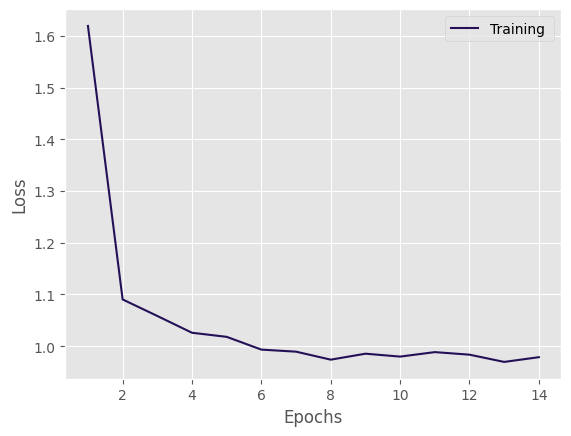

In [15]:
rfe.fit(X_num, target)

In [19]:
feature_names = NUMERIC_FEATURES + CAT_FEATURES

rfe_features = np.array(feature_names)[rfe.get_support()]
print(rfe_features)

['loading (g)' 'Adsorbent']


In [20]:
for k,v in FEATURES.items():
    print(k, v)

28 ['Pyrolysis_temp' 'Heating rate (oC)' 'Pyrolysis_time (min)' 'C' 'H' 'O'
 'N' 'Ash' 'H/C' 'O/C' 'N/C' '(O+N/C)' 'Surface area' 'Pore volume'
 'Average pore size' 'Adsorption_time (min)' 'Ci' 'solution pH' 'rpm'
 'Volume (L)' 'loading (g)' 'adsorption_temp' 'Ion Concentration (M)'
 'DOM' 'Adsorbent' 'Feedstock' 'inorganics' 'Anion_type']
27 ['Pyrolysis_temp' 'Heating rate (oC)' 'Pyrolysis_time (min)' 'C' 'H' 'O'
 'N' 'Ash' 'H/C' 'O/C' 'N/C' '(O+N/C)' 'Surface area' 'Pore volume'
 'Average pore size' 'Adsorption_time (min)' 'Ci' 'solution pH'
 'Volume (L)' 'loading (g)' 'adsorption_temp' 'Ion Concentration (M)'
 'DOM' 'Adsorbent' 'Feedstock' 'inorganics' 'Anion_type']
26 ['Pyrolysis_temp' 'Heating rate (oC)' 'Pyrolysis_time (min)' 'C' 'H' 'O'
 'N' 'H/C' 'O/C' 'N/C' '(O+N/C)' 'Surface area' 'Pore volume'
 'Average pore size' 'Adsorption_time (min)' 'Ci' 'solution pH'
 'Volume (L)' 'loading (g)' 'adsorption_temp' 'Ion Concentration (M)'
 'DOM' 'Adsorbent' 'Feedstock' 'inorganics' 'Anion

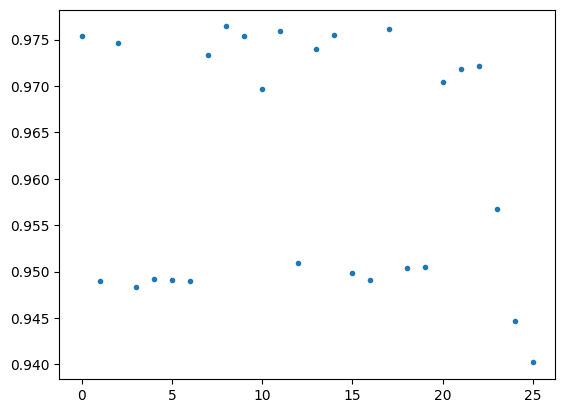

<AxesSubplot:>

In [23]:
plot(rfe.scores_, '.')

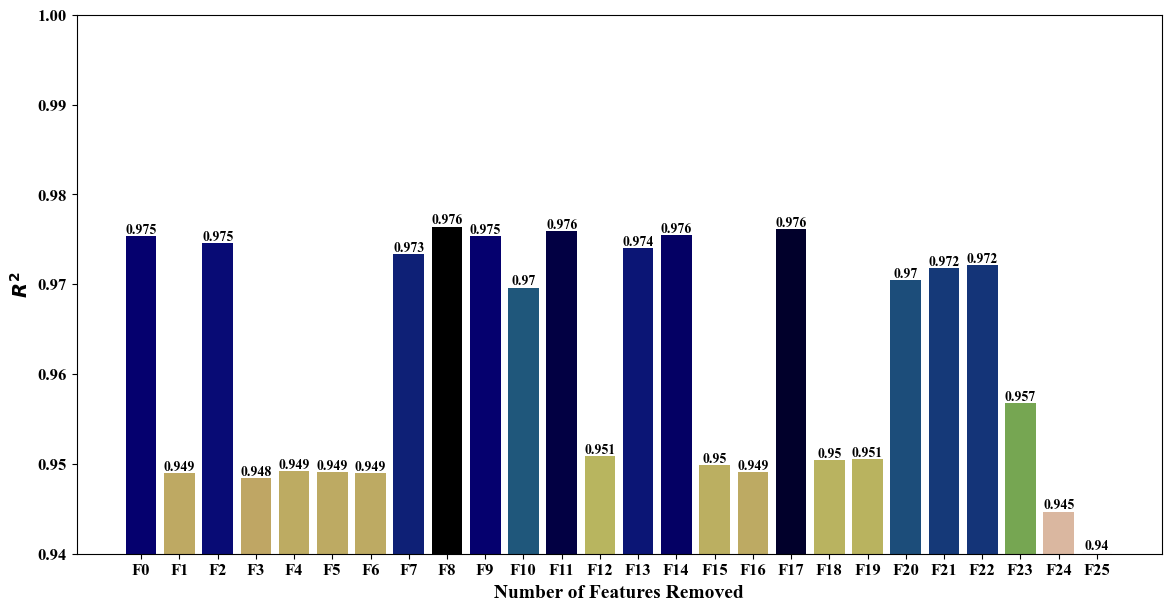

In [56]:
fig, ax = plt.subplots(figsize=(14, 7))
ax = bar_chart(rfe.scores_, orient="v", 
            bar_labels=np.round(rfe.scores_, 3),
               cmap="gist_earth_r",
               ax=ax,
    bar_label_kws={'label_type':'edge'},
               show=False)
ax.set_ylim(0.94, 1.0)
ax.set_xlabel("Number of Features Removed")
ax.set_ylabel("$R^{2}$")
plt.show()

## KFold Cross Validation

In [38]:
CV_TYPE = "KFold"
CV_SPLITS = 5

rfe = MyRFE(model, n_features_to_select=N_FEATURES_TO_SELECT,
          step=1,
            verbose=2)

In [39]:
rfe.fit(X_num, target, cv=True)

Fitting estimator with 28 features.
assigning name Input_num to IteratorGetNext:0 with shape (None, 24)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 24)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 24)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 24)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 24)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 24)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 24)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Inpu

assigning name Input_num to IteratorGetNext:0 with shape (None, 22)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 22)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 22)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 22)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 22)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 22)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 22)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shap

assigning name Input_num to IteratorGetNext:0 with shape (None, 19)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 19)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 19)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 19)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 19)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 19)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 19)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shap

assigning name Input_num to IteratorGetNext:0 with shape (None, 17)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 17)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 17)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 17)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 17)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 17)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 17)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shap

assigning name Input_num to IteratorGetNext:0 with shape (None, 14)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 14)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 14)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 14)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 14)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 14)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 14)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shap

assigning name Input_num to IteratorGetNext:0 with shape (None, 12)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 12)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 12)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 12)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 12)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 12)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 12)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shap

assigning name Input_num to IteratorGetNext:0 with shape (None, 9)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 9)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 9)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 9)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 9)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 9)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 9)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None

assigning name Input_num to IteratorGetNext:0 with shape (None, 7)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 7)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 7)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 7)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 7)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 7)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 7)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None

assigning name Input_num to IteratorGetNext:0 with shape (None, 5)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 3)
assigning name Input_num to IteratorGetNext:0 with shape (None, 5)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 3)
assigning name Input_num to IteratorGetNext:0 with shape (None, 5)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 3)
assigning name Input_num to IteratorGetNext:0 with shape (None, 5)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 3)
assigning name Input_num to IteratorGetNext:0 with shape (None, 5)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 3)
assigning name Input_num to IteratorGetNext:0 with shape (None, 5)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 3)
assigning name Input_num to IteratorGetNext:0 with shape (None, 5)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 3)
assigning name Input_num to IteratorGetNext:0 with shape (None

assigning name Input_num to IteratorGetNext:0 with shape (None, 4)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 2)
assigning name Input_num to IteratorGetNext:0 with shape (None, 4)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 2)
assigning name Input_num to IteratorGetNext:0 with shape (None, 4)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 2)
assigning name Input_num to IteratorGetNext:0 with shape (None, 4)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 2)
assigning name Input_num to IteratorGetNext:0 with shape (None, 4)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 2)
assigning name Input_num to IteratorGetNext:0 with shape (None, 4)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 2)
assigning name Input_num to IteratorGetNext:0 with shape (None, 4)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 2)
Fitting estimator with 5 features.
assigning name Input_num to

assigning name Input_num to IteratorGetNext:0 with shape (None, 2)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 1)
assigning name Input_num to IteratorGetNext:0 with shape (None, 2)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 1)
assigning name Input_num to IteratorGetNext:0 with shape (None, 2)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 1)
assigning name Input_num to IteratorGetNext:0 with shape (None, 2)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 1)
assigning name Input_num to IteratorGetNext:0 with shape (None, 2)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 1)
assigning name Input_num to IteratorGetNext:0 with shape (None, 2)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 1)
assigning name Input_num to IteratorGetNext:0 with shape (None, 2)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 1)
assigning name Input_num to IteratorGetNext:0 with shape (None

MyRFE(estimator=<ai4water.main.Model object at 0x000001FD498F01C8>,
      n_features_to_select=2, verbose=2)

In [40]:
feature_names = NUMERIC_FEATURES + CAT_FEATURES
rfe_features = np.array(feature_names)[rfe.get_support()]
print(rfe_features)

['loading (g)' 'Adsorbent']


In [41]:
for k,v in FEATURES.items():
    print(k, v)

28 ['Pyrolysis_temp' 'Heating rate (oC)' 'Pyrolysis_time (min)' 'C' 'H' 'O'
 'N' 'Ash' 'H/C' 'O/C' 'N/C' '(O+N/C)' 'Surface area' 'Pore volume'
 'Average pore size' 'Adsorption_time (min)' 'Ci' 'solution pH' 'rpm'
 'Volume (L)' 'loading (g)' 'adsorption_temp' 'Ion Concentration (M)'
 'DOM' 'Adsorbent' 'Feedstock' 'inorganics' 'Anion_type']
27 ['Pyrolysis_temp' 'Heating rate (oC)' 'Pyrolysis_time (min)' 'C' 'H' 'O'
 'N' 'Ash' 'H/C' 'O/C' 'N/C' '(O+N/C)' 'Surface area' 'Pore volume'
 'Average pore size' 'Adsorption_time (min)' 'Ci' 'solution pH'
 'Volume (L)' 'loading (g)' 'adsorption_temp' 'Ion Concentration (M)'
 'DOM' 'Adsorbent' 'Feedstock' 'inorganics' 'Anion_type']
26 ['Pyrolysis_temp' 'Heating rate (oC)' 'Pyrolysis_time (min)' 'C' 'H' 'O'
 'N' 'H/C' 'O/C' 'N/C' '(O+N/C)' 'Surface area' 'Pore volume'
 'Average pore size' 'Adsorption_time (min)' 'Ci' 'solution pH'
 'Volume (L)' 'loading (g)' 'adsorption_temp' 'Ion Concentration (M)'
 'DOM' 'Adsorbent' 'Feedstock' 'inorganics' 'Anion

In [42]:
set_rcParams()

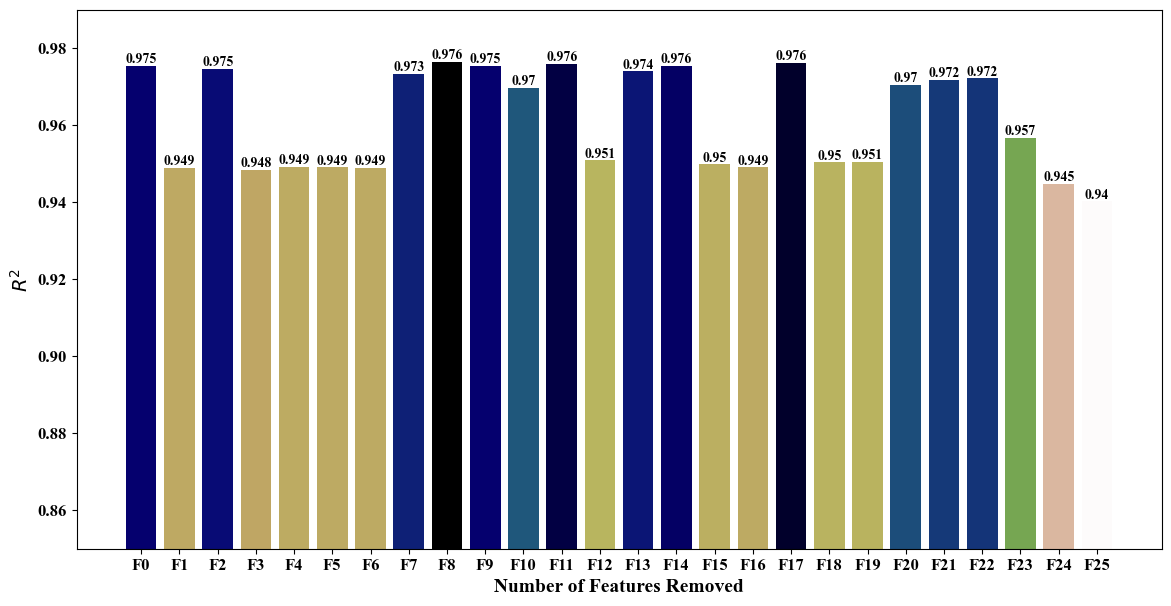

In [44]:
fig, ax = plt.subplots(figsize=(14, 7))

ax = bar_chart(rfe.scores_, 
               orient="v", 
               bar_labels=np.round(rfe.scores_, 3),
               cmap="gist_earth_r",
               ax=ax,
               bar_label_kws={'label_type':'edge'},
               show=False)
ax.set_ylim(0.85, 0.99)
ax.set_xlabel("Number of Features Removed")
ax.set_ylabel("$R^{2}$")
plt.show()

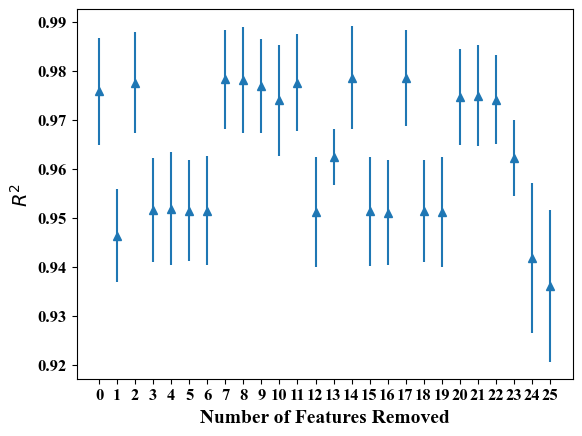

In [45]:
scores = np.array(rfe.cv_scores_)
std = scores.std(axis=1)
mean = scores.mean(axis=1)

x = np.arange(len(scores))
y = mean 
e = std
fig, axes = plt.subplots()
axes.errorbar(x, y, e, linestyle='None', marker='^')
axes.set_xticks(x)
axes.set_xlabel("Number of Features Removed")
axes.set_ylabel("$R^{2}$")
plt.show()

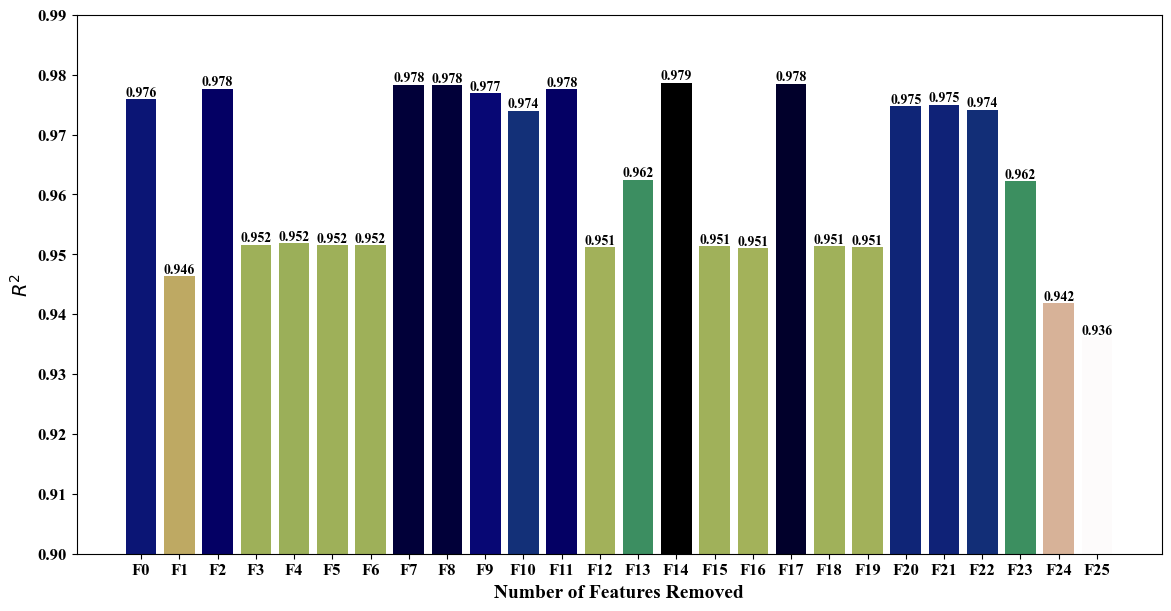

In [47]:
fig, ax = plt.subplots(figsize=(14, 7))

ax = bar_chart(y, 
               orient="v", 
               bar_labels=np.round(y, 3),
               cmap="gist_earth_r",
               ax=ax,
               bar_label_kws={'label_type':'edge'},
               show=False)
ax.set_ylim(0.9, 0.99)
ax.set_xlabel("Number of Features Removed")
ax.set_ylabel("$R^{2}$")
plt.show()

## Grouped KFold

In [11]:
CV_SPLITS = 5

CV_TYPE = "GroupKFold"
FEATURES = {}

In [12]:
col = 'Adsorbent'
splitter = TrainTestSplit(seed=1000)
cv = splitter.KFold(X_num, target, n_splits=CV_SPLITS)
for idx, ((train_X, train_y), (test_X, test_y)) in enumerate(cv):
    train_X = pd.DataFrame(train_X, columns=X_num.columns)
    test_X = pd.DataFrame(test_X, columns=X_num.columns)
    print(idx, train_X.loc[:, 'Adsorbent'].unique(), test_X.loc[:, 'Adsorbent'].unique())


0 [ 0.  8. 13.  1. 15. 14.  2.  4. 12.  3. 11.  9. 10.  5.  7.  6.] [ 0.  8. 13.  1. 15. 14.  2.  4. 12.  3. 11.  9. 10.  6.  7.  5.]
1 [ 0.  8. 13.  1. 15. 14.  2.  4. 12.  3. 11.  9. 10.  5.  6.  7.] [ 0.  8. 13.  1. 15. 14.  2.  4. 12.  3. 11.  9. 10.  5.  7.  6.]
2 [ 0.  8. 13.  1. 15. 14.  2.  4. 12.  3. 11.  9. 10.  6.  7.  5.] [ 0.  8. 13.  1. 15. 14.  2.  4. 12.  3. 11.  9. 10.  5.  6.  7.]
3 [ 0.  8. 13.  1. 15. 14.  2.  4. 12.  3. 11.  9. 10.  5.  6.  7.] [ 0.  8. 13.  1. 15. 14.  2.  4. 12.  3. 11.  9. 10.  7.  5.  6.]
4 [ 0.  8. 13.  1. 15. 14.  2.  4. 12.  3. 11.  9. 10.  5.  6.  7.] [ 0.  8. 13.  1. 15. 14.  2.  4. 12.  3. 11.  9. 10.  6.  5.  7.]


We see that same groups are present in both training and test data which can give us over optimistic evaluation of our model

In [13]:
col = 'Adsorbent'
groups = X_num[col].values.astype(int)
splitter = TrainTestSplit(seed=1000)
cv = splitter.GroupKFold(X_num, target, n_splits=CV_SPLITS, groups=groups)
for idx, ((train_X, train_y), (test_X, test_y)) in enumerate(cv):
    train_X = pd.DataFrame(train_X, columns=X_num.columns)
    test_X = pd.DataFrame(test_X, columns=X_num.columns)
    print(idx, train_X.loc[:, 'Adsorbent'].unique(), test_X.loc[:, 'Adsorbent'].unique())


0 [ 0. 13.  1. 14.  2.  4. 12.  3. 11.  9. 10.  5.  6.  7.] [ 8. 15.]
1 [ 8. 13.  1. 15.  2.  4. 12.  3. 11.  9. 10.  5.  6.  7.] [ 0. 14.]
2 [ 0.  8.  1. 15. 14.  4. 12.  3.  9. 10.  5.  7.] [13.  2. 11.  6.]
3 [ 0.  8. 13. 15. 14.  2. 12.  3. 11.  9.  5.  6.] [ 1.  4. 10.  7.]
4 [ 0.  8. 13.  1. 15. 14.  2.  4. 11. 10.  6.  7.] [12.  3.  9.  5.]


In [14]:

rfe = MyRFE(model, n_features_to_select=N_FEATURES_TO_SELECT,
          step=1,
            verbose=2)

Fitting estimator with 28 features.
assigning name Input_num to IteratorGetNext:0 with shape (None, 24)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 24)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 24)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 24)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 24)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 24)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 24)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Inpu

assigning name Input_num to IteratorGetNext:0 with shape (None, 22)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 22)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 22)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 22)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 22)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (32, 22)
assigning name Input_cat to IteratorGetNext:1 with shape (32, 4)
assigning name Input_num to IteratorGetNext:0 with shape (32, 22)
assigning name Input_cat to IteratorGetNext:1 with shape (32, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None,

assigning name Input_num to IteratorGetNext:0 with shape (None, 19)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 19)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 19)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 19)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 19)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 19)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 19)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shap

assigning name Input_num to IteratorGetNext:0 with shape (None, 17)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 17)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 17)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (32, 17)
assigning name Input_cat to IteratorGetNext:1 with shape (32, 4)
assigning name Input_num to IteratorGetNext:0 with shape (32, 17)
assigning name Input_cat to IteratorGetNext:1 with shape (32, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 17)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 17)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None,

assigning name Input_num to IteratorGetNext:0 with shape (None, 14)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 14)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 14)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 14)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 14)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 14)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 14)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shap

assigning name Input_num to IteratorGetNext:0 with shape (None, 12)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (32, 12)
assigning name Input_cat to IteratorGetNext:1 with shape (32, 4)
assigning name Input_num to IteratorGetNext:0 with shape (32, 12)
assigning name Input_cat to IteratorGetNext:1 with shape (32, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 12)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 12)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 12)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 12)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
Fitting estimator with 15 features.
assigning name Input_num to

assigning name Input_num to IteratorGetNext:0 with shape (None, 9)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 9)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 9)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 9)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 9)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 9)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 9)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None

assigning name Input_num to IteratorGetNext:0 with shape (32, 7)
assigning name Input_cat to IteratorGetNext:1 with shape (32, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 7)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 7)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 7)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 7)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
Fitting estimator with 10 features.
assigning name Input_num to IteratorGetNext:0 with shape (None, 6)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to IteratorGetNext:0 with shape (None, 6)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 4)
assigning name Input_num to It

assigning name Input_num to IteratorGetNext:0 with shape (None, 5)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 3)
assigning name Input_num to IteratorGetNext:0 with shape (None, 5)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 3)
assigning name Input_num to IteratorGetNext:0 with shape (None, 5)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 3)
assigning name Input_num to IteratorGetNext:0 with shape (None, 5)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 3)
assigning name Input_num to IteratorGetNext:0 with shape (None, 5)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 3)
assigning name Input_num to IteratorGetNext:0 with shape (None, 5)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 3)
assigning name Input_num to IteratorGetNext:0 with shape (None, 5)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 3)
assigning name Input_num to IteratorGetNext:0 with shape (None

assigning name Input_num to IteratorGetNext:0 with shape (None, 4)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 2)
assigning name Input_num to IteratorGetNext:0 with shape (None, 4)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 2)
assigning name Input_num to IteratorGetNext:0 with shape (None, 4)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 2)
Fitting estimator with 5 features.
assigning name Input_num to IteratorGetNext:0 with shape (None, 4)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 1)
assigning name Input_num to IteratorGetNext:0 with shape (None, 4)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 1)
assigning name Input_num to IteratorGetNext:0 with shape (None, 4)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 1)
assigning name Input_num to IteratorGetNext:0 with shape (None, 4)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 1)
assigning name Input_num to

assigning name Input_num to IteratorGetNext:0 with shape (None, 2)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 1)
assigning name Input_num to IteratorGetNext:0 with shape (None, 2)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 1)
assigning name Input_num to IteratorGetNext:0 with shape (None, 2)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 1)
assigning name Input_num to IteratorGetNext:0 with shape (None, 2)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 1)
assigning name Input_num to IteratorGetNext:0 with shape (None, 2)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 1)
assigning name Input_num to IteratorGetNext:0 with shape (None, 2)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 1)
assigning name Input_num to IteratorGetNext:0 with shape (None, 2)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 1)
assigning name Input_num to IteratorGetNext:0 with shape (None

MyRFE(estimator=<ai4water.main.Model object at 0x0000020BCC7E3A48>,
      n_features_to_select=2, verbose=2)

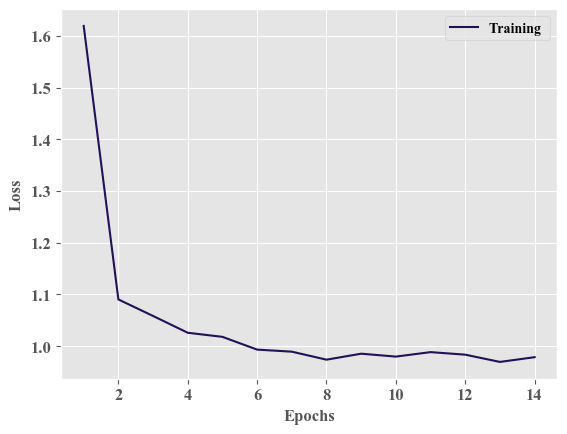

In [15]:
rfe.fit(X_num, target, cv=True)

In [16]:
feature_names = NUMERIC_FEATURES + CAT_FEATURES
rfe_features = np.array(feature_names)[rfe.get_support()]
print(rfe_features)

['loading (g)' 'Adsorbent']


In [17]:
for k,v in FEATURES.items():
    print(k, v)

28 ['Pyrolysis_temp' 'Heating rate (oC)' 'Pyrolysis_time (min)' 'C' 'H' 'O'
 'N' 'Ash' 'H/C' 'O/C' 'N/C' '(O+N/C)' 'Surface area' 'Pore volume'
 'Average pore size' 'Adsorption_time (min)' 'Ci' 'solution pH' 'rpm'
 'Volume (L)' 'loading (g)' 'adsorption_temp' 'Ion Concentration (M)'
 'DOM' 'Adsorbent' 'Feedstock' 'inorganics' 'Anion_type']
27 ['Pyrolysis_temp' 'Heating rate (oC)' 'Pyrolysis_time (min)' 'C' 'H' 'O'
 'N' 'Ash' 'H/C' 'O/C' 'N/C' '(O+N/C)' 'Surface area' 'Pore volume'
 'Average pore size' 'Adsorption_time (min)' 'Ci' 'solution pH'
 'Volume (L)' 'loading (g)' 'adsorption_temp' 'Ion Concentration (M)'
 'DOM' 'Adsorbent' 'Feedstock' 'inorganics' 'Anion_type']
26 ['Pyrolysis_temp' 'Heating rate (oC)' 'Pyrolysis_time (min)' 'C' 'H' 'O'
 'N' 'H/C' 'O/C' 'N/C' '(O+N/C)' 'Surface area' 'Pore volume'
 'Average pore size' 'Adsorption_time (min)' 'Ci' 'solution pH'
 'Volume (L)' 'loading (g)' 'adsorption_temp' 'Ion Concentration (M)'
 'DOM' 'Adsorbent' 'Feedstock' 'inorganics' 'Anion

In [18]:
scores = np.array(rfe.cv_scores_)
std = scores.std(axis=1)
mean = scores.mean(axis=1)

scores.shape

(26, 5)

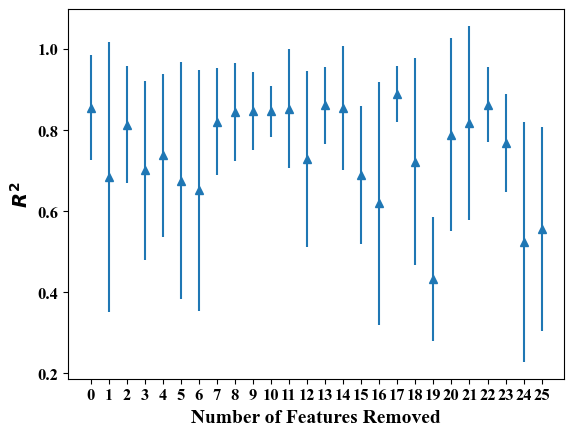

In [19]:

x = np.arange(len(scores))
y = mean 
e = std
fig, axes = plt.subplots()
axes.errorbar(x, y, e, linestyle='None', marker='^')
axes.set_xticks(x)
axes.set_xlabel("Number of Features Removed")
axes.set_ylabel("$R^{2}$")
plt.show()

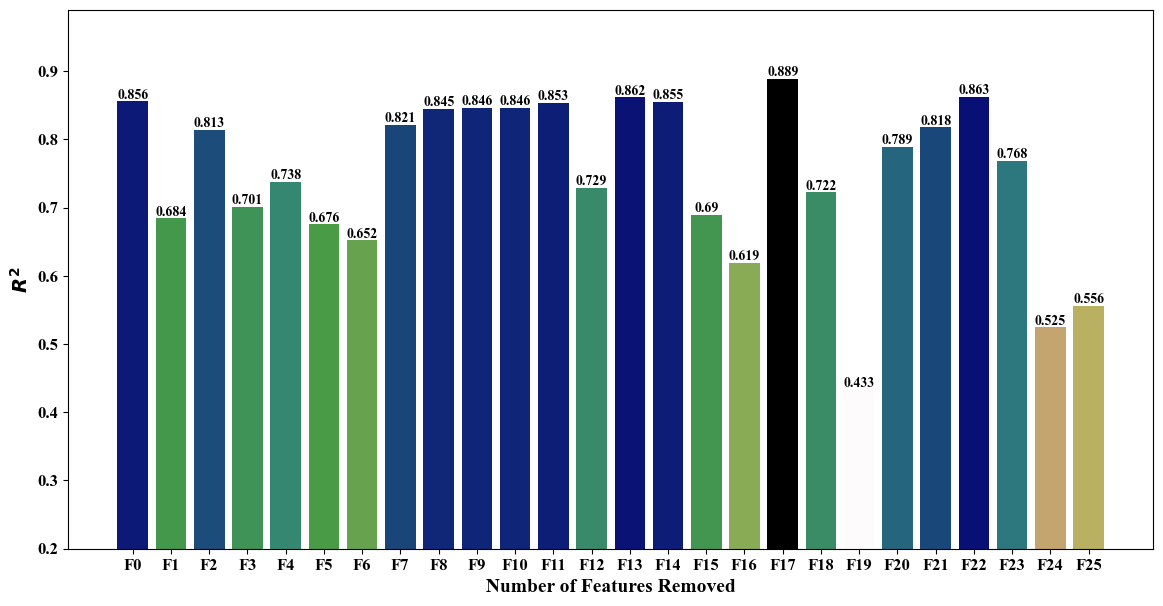

In [21]:
fig, ax = plt.subplots(figsize=(14, 7))

ax = bar_chart(y, 
               orient="v", 
               bar_labels=np.round(y, 3),
               cmap="gist_earth_r",
               ax=ax,
               bar_label_kws={'label_type':'edge'},
               show=False)
ax.set_ylim(0.2, 0.99)
ax.set_xlabel("Number of Features Removed")
ax.set_ylabel("$R^{2}$")
plt.show()